In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
data = pd.read_csv("data/performance_year_financial_and_quality_results_puf_2020_01_01.csv")
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_seq_items = 1000

In [3]:
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss","BnchmkMinExp"] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

x = data_mod.drop(['Sav_rate'], axis=1).values
y = data_mod['Sav_rate'].values

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=109)

## Gradient Boosting v. Bagging Regressors

In [5]:
l_rate = 0.05
n_estimators = 30

# Initialise a Boosting model using sklearn's boosting model 
# Use 1000 estimators, depth of 1 and learning rate as defined above
boosted_model  = GradientBoostingRegressor(n_estimators=n_estimators,
                                        max_depth=1,
                                        learning_rate=l_rate)

# Fit on the train data
boosted_model.fit(x_train, y_train)

# Predict on the test data
y_pred_boost = boosted_model.predict(x_test)


In [6]:
# Specify the number of bootstraps
num_bootstraps = 30

# Specify the maximum depth of the decision tree
max_depth = 10

# Define the Bagging Regressor Model
# Use Decision Tree as your base estimator with depth as mentioned in max_depth
# Initialise number of estimators using the num_bootstraps value
# Set max_samples as 0.8 and random_state as 3
model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                        n_estimators=num_bootstraps,
                        max_samples=0.8,
                        random_state=109)
                        

# Fit the model on the train data
model.fit(x_train, y_train)
y_pred_bag = model.predict(x_test)

### Error

In [7]:
print(f'Boosting error: {mean_squared_error(y_test, y_pred_boost):.3f}.')
print(f'Bagging error: {mean_squared_error(y_test, y_pred_bag):.3f}.')

Boosting error: 0.002.
Bagging error: 0.002.


### Important Features in bagging model

In [8]:
# Specify the number of bootstraps
num_bootstraps = 30

# Specify the maximum depth of the decision tree
max_depth = 10

top_predictors_bag = pd.Series(index=data.drop('Sav_rate', axis=1).columns, dtype=int)
for j in range(10):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                        n_estimators=num_bootstraps,
                        max_samples=0.8,
                        random_state=109)
    model.fit(x_train, y_train)
    for i in range(num_bootstraps):
        top_predictors_bag[model.estimators_[i].tree_.feature[0]] += 1

top_predictors_bag /= 10
top_predictors_bag.loc[top_predictors_bag > 0].sort_values(ascending=False)

N_Ben_Female                   6.0
Per_Capita_Exp_ALL_ESRD_BY1    5.0
prov_Rate_1000                 3.0
ADM_L_Trm                      2.0
N_AB_Year_AGED_Dual_BY3        2.0
Rev_Exp_Cat                    2.0
N_CAH                          1.0
P_SNF_ADM                      1.0
P_FQHC_RHC_Vis                 1.0
ADM                            1.0
CapAnn_OPD                     1.0
N_Ben_Race_Native              1.0
N_Ben_Race_Hisp                1.0
N_Ben_Age_85plus               1.0
Per_Capita_Exp_ALL_AGDU_BY3    1.0
RevLossLimit                   1.0
dtype: float64

### Important Features in gradient boosting model

In [9]:
l_rate = 0.05
n_estimators = 30

top_predictors_boost = pd.Series(index=data.drop('Sav_rate', axis=1).columns, dtype=int)
for j in range(10):
    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                            max_depth=1,
                                            learning_rate=l_rate)
    model.fit(x_train, y_train)
    for i in range(n_estimators):
        top_predictors_boost[model.estimators_[i][0].tree_.feature[0]] += 1

top_predictors_boost /= 10
top_predictors_boost.loc[top_predictors_boost > 0].sort_values(ascending=False)

prov_Rate_1000                 5.0
Per_Capita_Exp_ALL_ESRD_BY1    5.0
N_Ben_Female                   4.0
N_Ben_Age_85plus               4.0
Rev_Exp_Cat                    4.0
N_CAH                          3.3
ADM_L_Trm                      2.0
P_SNF_ADM                      1.7
CapAnn_HSP                     1.0
dtype: float64

### How does the number of estimators affect gradient boosting accuracy?

In [10]:
max_estimators = 100
boost_mses = []
for i in range(10, max_estimators+1):
    model = GradientBoostingRegressor(n_estimators=i,
                                        max_depth=1,
                                        learning_rate=l_rate)

    # Fit on the train data
    model.fit(x_train, y_train)

    # Predict on the test data
    y_pred_boost = model.predict(x_test)
    boost_mses.append(mean_squared_error(y_test, y_pred_boost))
    

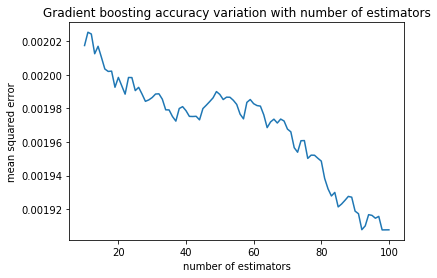

In [11]:
plt.plot(range(10, max_estimators+1), boost_mses)
plt.xlabel("number of estimators")
plt.ylabel("mean squared error")
plt.title("Gradient boosting accuracy variation with number of estimators")
plt.savefig('figures/gb_mse_nestm.pdf', bbox_inches="tight")

### How does learning rate affect gradient boosting accuracy?

In [12]:
max_lrate = 0.3
lrates = np.linspace(0.01, max_lrate, 300)
boost_mses = []
for lrate in lrates:
    model = GradientBoostingRegressor(n_estimators=100,
                                        max_depth=1,
                                        learning_rate=lrate)

    # Fit on the train data
    model.fit(x_train, y_train)

    # Predict on the test data
    y_pred_boost = model.predict(x_test)
    boost_mses.append(mean_squared_error(y_test, y_pred_boost))

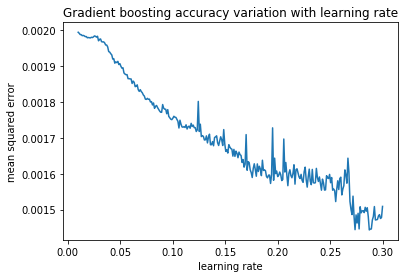

In [13]:
plt.plot(lrates, boost_mses)
plt.xlabel("learning rate")
plt.ylabel("mean squared error")
plt.title("Gradient boosting accuracy variation with learning rate")
plt.savefig('figures/gb_mse_lrate.pdf', bbox_inches="tight")

### How does the depth of the trees affect bagging accuracy?

In [14]:
max_depth = 15
bag_mses = []
bag_oob_scores = []
for depth in range(1, max_depth+1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=depth),
                              n_estimators=num_bootstraps,
                              max_samples=0.8,
                              oob_score=True,
                              random_state=109)

    # Fit on the train data
    model.fit(x_train, y_train)

    # Predict on the test data
    y_pred_bag = model.predict(x_test)
    bag_mses.append(mean_squared_error(y_test, y_pred_bag))
    bag_oob_scores.append(model.oob_score_)

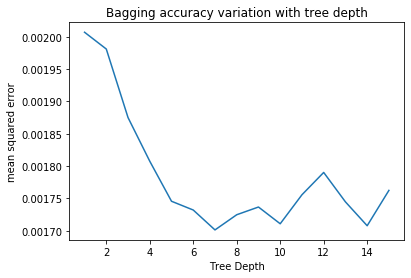

In [15]:
plt.plot(range(1, max_depth+1), bag_mses)
plt.xlabel("Tree Depth")
plt.ylabel("mean squared error")
plt.title("Bagging accuracy variation with tree depth")
plt.savefig('figures/bag_mse_depth.pdf', bbox_inches="tight")

### How does the depth of the trees affect bagging oob score?

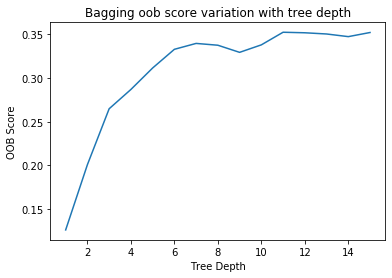

In [16]:
plt.plot(range(1, max_depth+1), bag_oob_scores)
plt.xlabel("Tree Depth")
plt.ylabel("OOB Score")
plt.title("Bagging oob score variation with tree depth")
plt.savefig('figures/bag_oob_depth.pdf', bbox_inches="tight")

### How does the number of bootstraps affect bagging accuracy?

In [17]:
max_bootstraps = 30
num_bootstraps = range(10, max_bootstraps+1)
max_depth = 10
bag_mses = []
bag_oob_scores = []
for n_bootstraps in num_bootstraps:
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                              n_estimators=n_bootstraps,
                              max_samples=0.8,
                              oob_score=True,
                              random_state=109)

    # Fit on the train data
    model.fit(x_train, y_train)

    # Predict on the test data
    y_pred_bag = model.predict(x_test)
    bag_mses.append(mean_squared_error(y_test, y_pred_bag))
    bag_oob_scores.append(model.oob_score_)

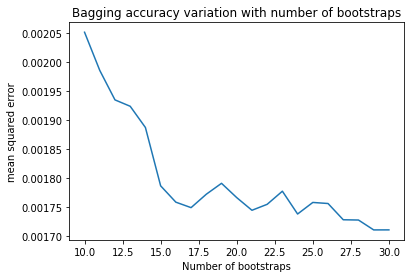

In [18]:
plt.plot(num_bootstraps, bag_mses)
plt.xlabel("Number of bootstraps")
plt.ylabel("mean squared error")
plt.title("Bagging accuracy variation with number of bootstraps")
plt.savefig('figures/bag_mse_nboots.pdf', bbox_inches="tight")

### How does the number of bootstraps affect bagging oob score?

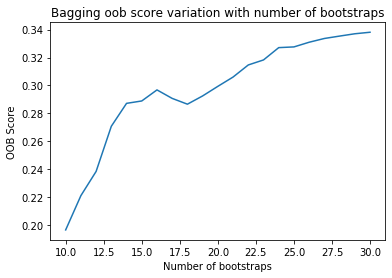

In [19]:
plt.plot(num_bootstraps, bag_oob_scores)
plt.xlabel("Number of bootstraps")
plt.ylabel("OOB Score")
plt.title("Bagging oob score variation with number of bootstraps")
plt.savefig('figures/bag_oob_nboots.pdf', bbox_inches="tight")